# Approximate/compressed contraction

In this example we use `cotengra` to find a 'compressed' contraction tree
(as detailed in [2206.07044](https://arxiv.org/abs/2206.07044)) for a $10\times10\times10$
tensor network representation of the partition function of the 3D classical
ising model. We then use `quimb` to actually perform the compressed
contraction.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg
import quimb.tensor as qtn

First we get the tensor network from `quimb`, though note we could also specify it as usual via
`inputs`, `output` and `size_dict`.

In [2]:
tn = qtn.TN3D_classical_ising_partition_function(
    10, 10, 10, beta=0.3
)

Then we set-up our *compressed* contraction tree finder:

In [3]:
chi = 16
copt = ctg.ReusableHyperCompressedOptimizer(
    chi,
    max_repeats=256,
    minimize='combo-compressed', 
    progbar=True,
    # # save paths to disk:
    # directory=True  
)

`quimb` knows about `cotengra` and will directly return the 
`ContractionTreeCompressed` generated during the search:

In [4]:
tree = tn.contraction_tree(copt)

log2[SIZE]: 21.00 log10[FLOPs]: 10.89: 100%|████████████████████████| 256/256 [00:15<00:00, 16.02it/s]


We can perform various bits of introspection on both the compressed contraction tree and optimizer now
before we actually perform the contraction.

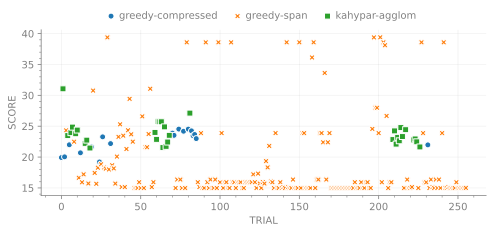

(<Figure size 800x300 with 1 Axes>, <Axes: xlabel='TRIAL', ylabel='SCORE'>)

In [5]:
copt.last_opt.plot_trials()

We can see that the best tree was generated with the Span algorithm, so we can visualize the actual spanning tree like so:

In [6]:
tree.plot_span(
    node_max_size=1, 
    edge_max_width=1, 
    edge_color='order', 
    node_color='order',
    edge_colormap='Spectral_r',
    node_colormap='Spectral_r',
    colorbars=False,
)

(<Figure size 500x500 with 1 Axes>, <Axes: >)

Here we optionally convert to GPU arrays to make the contraction (much) quicker:

In [7]:
def to_backend(x):
    import torch

    return torch.tensor(x, dtype=torch.float32, device='cuda')

tn.apply_to_arrays(to_backend)

Now we actually perform the contraction, this requires a lot of machinery
that only `quimb` can provide currently, so we just need to supply either
the raw path or optimizer to the following method:

In [8]:
tn.contract_compressed_(
    optimize=tree.get_path(),  # or optimize=copt
    max_bond=chi,
    equalize_norms=1.0,
    progbar=True,
)

log2[SIZE]: 0.00/21.00: 100%|███████████████████████████████████████| 999/999 [00:11<00:00, 90.42it/s]


TensorNetwork3D(tensors=1, indices=0, Lx=10, Ly=10, Lz=10, max_bond=1)

Note becuase its a large contraction, we perform in inplace and accumulate the norms of all intermediate tensors into `tn.exponent`.

In [9]:
mantissa, exponent = (tn.contract(), tn.exponent)
mantissa, exponent

(tensor(1., device='cuda:0'), tensor(379.5602, device='cuda:0'))

So our final partition function is $Z=1\times10^{379.5602}$.

If we just change the entries of the tensor network (and not the actual geometry) then we can reuse the same path or optimizer.
For example here we just change the inverse temperature of the model, $\beta$:

In [10]:
tn = qtn.TN3D_classical_ising_partition_function(
    10, 10, 10, beta=0.25
)
tn.apply_to_arrays(to_backend)

In [11]:
tn.contract_compressed_(
    optimize=copt,  # here we demonstrate the cache of the optimizer
    max_bond=chi,
    equalize_norms=1.0,
    progbar=True,
)

log2[SIZE]: 0.00/21.00: 100%|███████████████████████████████████████| 999/999 [00:10<00:00, 91.62it/s]


TensorNetwork3D(tensors=1, indices=0, Lx=10, Ly=10, Lz=10, max_bond=1)

In [12]:
mantissa, exponent = (tn.contract(), tn.exponent)
mantissa, exponent

(tensor(1., device='cuda:0'), tensor(344.7334, device='cuda:0'))